# Stochastic Simulation Assignment 1

## Computing the Area of the Mandelbrot Set
_Authors: Sai Vinay Vardhan Daliparthi (15073815), Boyan Mihaylov (15067602), Nitai Nijholt (12709018)_

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns
import os
import random
from scipy import stats
from scipy import constants

## Mandelbrot Simulation

The following functions compute the Mandelbrot set by iterating a regular rectangular grid of complex numbers through a recursive function.

In [2]:
# creating the coordinate plane
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
wsteps, hsteps = 1000, 1000
r1 = np.linspace(xmin, xmax, wsteps)
r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
real_array, complex_array = np.meshgrid(r1,r2_imaginary)
complex_coordinate_plane = real_array + complex_array


In [3]:
def vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold):
    z = complex_coordinate_plane.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + complex_coordinate_plane[~diverged]

    return diverged_at

    

In [4]:
def calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,max_iter, threshold):
    r1 = np.linspace(xmin, xmax, wsteps)
    r2_imaginary = np.linspace(ymin*1j, ymax*1j, hsteps)
    real_array, complex_array = np.meshgrid(r1,r2_imaginary)
    complex_coordinate_plane = real_array + complex_array
    output = vectorized_mandlebrot(complex_coordinate_plane, max_iter, threshold)
    return output

        


-7.2900000000000005e-06


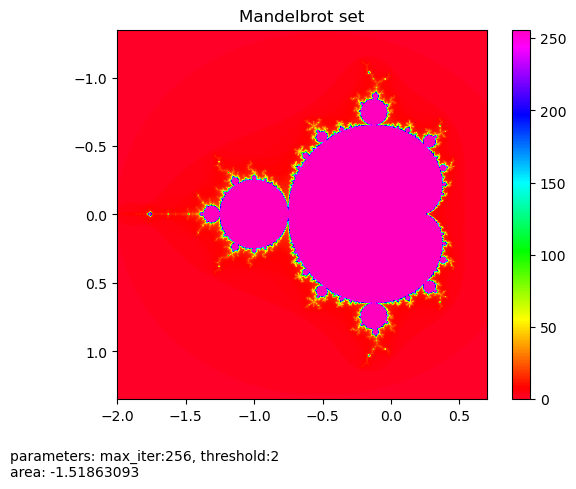

In [6]:
# xmin, xmax, ymin, ymax = -1.3, -1.05, -0.45, -0.2
# wsteps, hsteps = 1000, 1000


xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35,
wsteps, hsteps = 1000, 1000
max_iter = 256
threshold = 2


test_vectorized_mandelbrot = calculate_mandelbrot_vectorized(xmin,xmax,ymin,ymax,wsteps,hsteps,256, 2)
pt_area = (xmax - xmin) * (ymax - ymin) / (wsteps * hsteps)
area = np.sum(np.where(test_vectorized_mandelbrot == np.max(test_vectorized_mandelbrot), 1, 0)) * pt_area
plt.imshow(test_vectorized_mandelbrot, extent=(xmin, xmax, ymin, ymax), cmap='gist_rainbow')
plt.title("Mandelbrot set")
plt.figtext(0,-0.05,f'parameters: max_iter:{max_iter}, threshold:{threshold}\narea: {area}', horizontalalignment='left')
plt.colorbar()
plt.show()

## Approximating the Area by Pixel Counting

For a dense rectangular grid of points it is assumed that the area around the point can be calculated as:

$$
A_{pt}=\frac{1}{n_x n_y}A_R
$$

where $A_R$ is the area of the bounding region ($A_R=w\times h$) and $n_x$ and $n_y$ are the number of grid cells in $x$ and $y$ direction, respectively.

Then, to calculate the area $A_M$ of the Mandelbrot set we count the points which do not escape under the iteration function ($N_M$) and approximate the area as:

$$
A_M = N_M A_{pt}
$$

## Simulation Framework

The framework constructed below consists of the following modules:

[Sample Generator] -> [Complex Converter] -> [Mandelbrot Iterator] -> [Area Estimator] -> [Statistics Plotting Function]

An additional procedure plots an instance of the sampling distribution tothether with the results of the Mandelbrot iteration.

### Mandelbrot Iterator

In [17]:
def mandelbrot(c, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a given complex number c.
    Returns the number of iterations until divergence beyond threshold.'''
    z = 0
    for n in range(max_iter):
        if abs(z) > threshold:
            return n
        z = z**2 + c
    return max_iter

In [18]:
def vectorized_mandelbrot(samples_complex, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a numpy array of complex numbers.
    Returns the number of iterations until divergence beyond threshold.'''
    z = samples_complex.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + samples_complex[~diverged]

    return diverged_at

In [19]:
def vectorized_mandelbrot_z(samples_complex, max_iter, threshold=2):
    '''Calculates the number of iterations until divergence for a numpy array of complex numbers.
    Returns the number of iterations until divergence beyond threshold and the iterated complex number at the last iteration.'''
    z = samples_complex.copy()
    diverged_at = np.full(z.shape, max_iter)

    for n in range(max_iter):
        diverged = abs(z) > threshold
        diverged_at[diverged & (diverged_at == max_iter)] = n
        z[~diverged] = z[~diverged]**2 + samples_complex[~diverged]

    return diverged_at, z

### Utility Functions

In [20]:
def coords_to_complex(coords_array):
    '''Takes an input array of shape (2, sample_size) containing
    the x coordinates in the first row and the y coordinates in the second.
    Converts this array to complex numbers.
    '''
    return coords_array[0] + coords_array[1]*1j

In [21]:
def get_median_divisor(number):
    '''Returns the median of all the divisors for a number.
    '''
    divisors = np.array([x for x in range(1, int(number) + 1) if number % x == 0])
    
    return divisors[int(0.5*len(divisors))]

In [22]:
def get_second_divisor(number):
    '''Returns the median of all the divisors for a number.
    '''
    divisors = np.array([x for x in range(1, int(number) + 1) if number % x == 0])
    
    return divisors[1]

In [23]:
def check_grid_status(xmin, xmax, ymin, ymax, n_p, max_iter):
    """
    Function to check whether a square boundary is inside, outside, or on the boundary of the mandelbrot set.
    n_p is the number of points to sample on the edge of the boundary
    """
    
    # create an array of n points on the boundary

    x_1 = np.full((n_p-1,),xmin)
    y_1 = np.linspace(ymin*1j, ymax*1j, n_p)[:-1]
    points_1 =  x_1 + y_1
    x_2 = np.linspace(xmax, xmin, n_p)[:-1]
    y_2 = np.full((n_p-1,),ymax*1j)
    points_2 =  x_2 + y_2
    x_3 = np.full((n_p-1,),xmax)
    y_3 = np.linspace(ymax*1j, ymin*1j, n_p)[:-1]
    points_3 =  x_3 + y_3
    x_4 = np.linspace(xmin, xmax, n_p)[:-1]
    y_4 = np.full((n_p-1,),ymin*1j)
    points_4 =  x_1 + y_1

    # points_i contains the points on one side of the grid boundary
    points = np.concatenate((points_1, points_2, points_3, points_4))

    diverged_at = vectorized_mandelbrot(points, max_iter)

    if (diverged_at == np.full(diverged_at.shape,max_iter)).all():
        return 'in_set'
    elif (diverged_at != np.full(diverged_at.shape,max_iter)).all():
        return 'out_set'
    else:
        return 'boundary'
    
    return None

print(check_grid_status(0., 0.5, 0, 0.5, 10000, 256))
print(check_grid_status(0.1, 0.2, 0.1, 0.2, 10000, 256))

boundary
in_set


In [24]:
def create_subgrids(xmin, xmax, ymin, ymax, rows, cols):
    '''Creates an array of rectangular intervals inside an input region.
    '''
    
    subgrids = []

    # Calculate the step size for rows and columns
    row_step = (ymax - ymin) / rows
    col_step = (xmax - xmin) / cols

    # Loop through rows and columns to create subgrids
    for i in range(rows):
        for j in range(cols):
            # Calculate vertices of the current subgrid
            subgrid_xmin = xmin + j * col_step
            subgrid_xmax = subgrid_xmin + col_step
            subgrid_ymin = ymin + i * row_step
            subgrid_ymax = subgrid_ymin + row_step

            # Store vertices in a dictionary
            subgrid = {
                'xmin': subgrid_xmin,
                'xmax': subgrid_xmax,
                'ymin': subgrid_ymin,
                'ymax': subgrid_ymax
            }

            # Add the subgrid to the list
            subgrids.append(subgrid)

    return subgrids

# Example usage
xmin, xmax, ymin, ymax = 1, 5, 2, 6
rows, cols = 2, 2
subgrids = create_subgrids(xmin, xmax, ymin, ymax, rows, cols)

# Print the result
for i, subgrid in enumerate(subgrids, start=1):
    print(f"Subgrid {i}: {subgrid}")

Subgrid 1: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 2: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 3: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 4.0, 'ymax': 6.0}
Subgrid 4: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 4.0, 'ymax': 6.0}


### Area Estimation

In [25]:
def calc_area(xmin, xmax, ymin, ymax, iter_vals, half=False):
    '''Estimates the area of the Mandelbrot set by counting
    the sample points which did not escape during the iteration
    and computing their fraction from the entire sample number.
    '''
    
    sample_size = iter_vals.shape[0]
    in_mandelbrot = np.sum(np.where(iter_vals == np.max(iter_vals), 1, 0))

    area_ratio = in_mandelbrot / sample_size
    total_area = (xmax - xmin) * (ymax - ymin)

    area = area_ratio * total_area
    
    # Double area if only half-space is sampled
    if half:
        area *= 2

    return area

### Sampling Methods

In [26]:
def grid_sampling(xmin, xmax, ymin, ymax, sample_size):
    '''Performs deterministic regular grid sampling
    '''
    samples_x = np.linspace(xmin, xmax, int(np.sqrt(sample_size)))
    samples_y = np.linspace(ymin, ymax, int(np.sqrt(sample_size)))
    samples_x_grid, samples_y_grid = np.meshgrid(samples_x, samples_y)

    return np.vstack((samples_x_grid.reshape((1, sample_size)), samples_y_grid.reshape((1, sample_size))))

In [27]:
def fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size):
    '''Creates a regular concentric sampling using a fibonacci spiral.
    the resulting samples are less than the input size due to
    truncation with the rectangular region
    '''

    radius = np.sqrt(max(abs(xmin), abs(xmax))**2 + max(abs(ymin), abs(ymax))**2)/np.sqrt(sample_size)
    ts = np.arange(0, sample_size, 1)
    samples_x = radius*np.sqrt(ts)*np.cos(ts*2*np.pi/constants.golden)
    samples_y = radius*np.sqrt(ts)*np.sin(ts*2*np.pi/constants.golden)

    sample_pts = np.vstack((samples_x, samples_y)).T

    sample_pts_culled = [sp for sp in sample_pts if xmin < sp[0] < xmax and ymin < sp[1] < ymax]

    sample_pts_culled = np.array(sample_pts_culled).T
    
    return sample_pts_culled

In [28]:
def pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs pure uniform random sampling over the given interval.
    '''
    
    if seed is not None:
        np.random.seed(seed)
    
    return np.random.uniform((xmin, ymin), (xmax, ymax), size=(sample_size, 2)).T

In [29]:
def latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=None):
    '''Performs latin hypercube sampling over the given interval.
    '''

    if seed is not None:
        np.random.seed(seed)

    # creating a list of x and y coordinates from the xmin, xmax, ymin, ymax
    # note that stepsize = samplesize, so that the number of samples is equal to the number of steps. This is a requirement for LHS, see: https://en.wikipedia.org/wiki/Latin_hypercube_sampling
    x_base = np.linspace(xmin, xmax, sample_size + 1)[:-1]
    y_base = np.linspace(ymin, ymax, sample_size + 1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    random.shuffle(x_base)
    random.shuffle(y_base)

    # adding a random value to the base grid
    x_coords = x_base + np.random.uniform(0, (xmax - xmin)/sample_size, size=x_base.shape)
    y_coords = y_base + np.random.uniform(0, (ymax - ymin)/sample_size, size=y_base.shape)
    
    return np.vstack([x_coords, y_coords])

In [30]:
def orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals, seed=None):
    '''Performs orthogonal sampling over the given interval.
    n_sub_intervals indicates the number of subdivisions per dimension inside a cell of the supergrid.
    '''

    n_intervals = int(np.sqrt(sample_size))
    
    # Guarantee that interval is a power of two and is divisible by number of subintervals
    if n_intervals%n_sub_intervals != 0:
        print("Mismatched grid parameters!")
        return None

    n_intervals = int(n_intervals)

    if seed is not None:
        np.random.seed(seed)
    
    # base coordinates for large grid cells
    x_base = np.linspace(xmin, xmax, n_intervals + 1)[:-1]
    y_base = np.linspace(ymin, ymax, n_intervals + 1)[:-1]

    x_grid_base, y_grid_base = np.meshgrid(x_base, y_base)

    x_grid_base = x_grid_base.flatten()
    y_grid_base = y_grid_base.flatten()

    # base coordinates for fine grid cells
    x_interval = (xmax - xmin) / n_intervals
    y_interval = (ymax - ymin) / n_intervals
    x_base_sub = np.linspace(0, x_interval, n_sub_intervals+1)[:-1]
    y_base_sub = np.linspace(0, y_interval, n_sub_intervals+1)[:-1]

    # permutations of x and y are made to ensure that LHS requirements are met
    x_base_sub_permutations = np.array([np.random.permutation(x_base_sub) for _ in range(n_intervals**2//n_sub_intervals)])
    y_base_sub_permutations = np.array([np.random.permutation(y_base_sub) for _ in range(n_intervals**2//n_sub_intervals)])
    x_base_sub_permutations = x_base_sub_permutations.flatten()
    y_base_sub_permutations = y_base_sub_permutations.flatten()

    # adding large grid coordinates + permuted fine grid coordinates + random component
    x_coords = x_grid_base + x_base_sub_permutations + np.random.uniform(0, x_interval/n_sub_intervals, size=x_grid_base.shape)
    y_coords = y_grid_base + y_base_sub_permutations + np.random.uniform(0, y_interval/n_sub_intervals, size=y_grid_base.shape)

    return np.vstack([x_coords, y_coords])

In [31]:
def boundary_sampling_method(xmin, xmax, ymin, ymax, iterations, rows, cols, samples_per_grid_boundary, samples_per_grid, total_samples):
    '''Uses deterministic pre-sampling to narrow down boundary region by
    sampling uniform arrays of points along the edges of the squares of a 
    predetermined grid. If an intersection with the Mandelbrot set is presumed,
    the square in question is sub-sampled using LHS.
    '''
    
    subgrids = create_subgrids(xmin, xmax, ymin, ymax, rows, cols)
    area = 0
    samples = 0
    subgrids_to_sample = []
    for subgrid in subgrids:
        xmin, xmax, ymin, ymax = subgrid.values()
        grid_status = check_grid_status(xmin, xmax, ymin, ymax, samples_per_grid_boundary, iterations)
        samples = samples + (4*samples_per_grid_boundary)
        if grid_status == 'in_set':
            area = area + ((xmax - xmin) * (ymax - ymin))
        elif grid_status== 'boundary':
            subgrids_to_sample.append(subgrid)
    samples_per_grid = int((total_samples - samples) / len(subgrids_to_sample))

    for subgrid in subgrids_to_sample:
        xmin, xmax, ymin, ymax = subgrid.values()
        pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, samples_per_grid)
        complex_samples = coords_to_complex(pt_samples)
        mandelbrot_iters = vectorized_mandelbrot(complex_samples, iterations)
        area += calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
        samples = samples + samples_per_grid

    return area, samples

### Plotting Method

In [32]:
def plot_samples_mandelbrot(xmin, xmax, ymin, ymax, samples, iter_vals, half=False, ax=None, **params):
    '''Plots the sampling distribution, indicating the relationship to the Mandelbrot set.
    The input **params takes the parameters used for the simulation
    '''

    if half: cb_shrink = 0.5
    else: cb_shrink = 1.0
    
    modify_fig = False
    if not ax:
        fig, ax = plt.subplots()
        fig.set_size_inches(6, 3*cb_shrink+2)
        modify_fig = True

    # plot grid for stratified methods
    if params['sampling_method'] == 'LHS' and samples.shape[0] <= 100:
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        ax.grid(which='minor')
    if params['sampling_method'] == 'Orthogonal Sampling' and samples.shape[0] <= 100:
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]//params['sub_lvl'] + 1), minor=False)
        ax.set_xticks(np.linspace(xmin, xmax, samples.shape[0]+1), minor=True)
        ax.set_yticks(np.linspace(ymin, ymax, samples.shape[0]+1), minor=True)
        ax.grid(which='both')
    
    scat = ax.scatter(samples.real, samples.imag, c=iter_vals, s=1000/samples.shape[0])
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
    ax.set_aspect('equal')

    if modify_fig:
        fig.suptitle(f"Mandelbrot set: {params['sampling_method']}")
        fig.text(0.1,-0.05,f"Parameters: max_iter: {params['max_iter']}, threshold: {params['threshold']}\narea: {params['area']}", horizontalalignment='left')
        fig.colorbar(scat, label='escape iterations', ax=ax, shrink=cb_shrink)

        plt.tight_layout()
        plt.show()
    
    return scat

### Statistics Calculation

In [33]:
def parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type, seed_range=None, half=False):
    '''Performs multiple simulations with different parameter combinations provided
    by the arrays sample_range and iter_range. If seed_range is not provided,
    consecutive seeds starting from zero are taken.
    Outputs a DataFrame containing the area estimation results.
    '''

    sim_table = np.empty((len(iter_range)*len(sample_range)*num_runs, 4))
    seed_ct = 0
    for i, iteration in enumerate(iter_range):
        for j, sample_size in enumerate(sample_range):
            for k in range(num_runs):
                if seed_range:
                    seed = seed_range[seed_ct]
                else:
                    seed = seed_ct
                
                # Determine sampling function
                match sampling_type:
                    case 'random': pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'LHS': pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size, seed=seed)
                    case 'ortho': pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, n_sub_intervals=get_median_divisor(np.sqrt(sample_size)), seed=seed)
                    case _: print("Invalid sampling function")
                
                complex_samples = coords_to_complex(pt_samples)
                mandelbrot_iters = vectorized_mandelbrot(complex_samples, iteration)
                area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)

                index = (i*len(sample_range) + j)*num_runs + k
                sim_table[index] = np.array([k, iteration, sample_size, area])

                seed_ct += 1
    
    df_simulations = pd.DataFrame(sim_table, columns=['Simulation', 'Iterations', 'Samples', 'Area'])
    df_simulations.insert(0, 'Strategy', np.full(df_simulations.shape[0], sampling_type))

    return df_simulations

## Run Functions

The procedure below explores details in different regions of the Mandelbrot set.

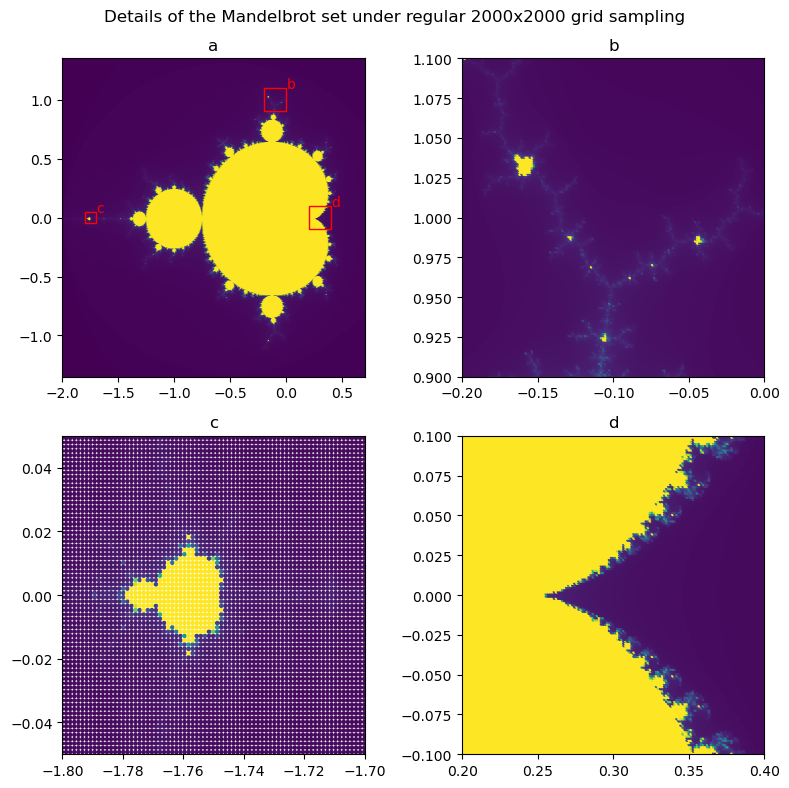

In [143]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 4000000
max_iter = 256

zoom_regions = [[[xmin, xmax], [ymin, ymax]],
                [[-0.2, 0], [0.9, 1.1]],
                [[-1.8, -1.7], [-0.05, 0.05]],
                [[0.2, 0.4], [-0.1, 0.1]]]

pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
mandelbrot_iters = mandelbrot_iters.reshape((int(np.sqrt(sample_size)), int(np.sqrt(sample_size))))

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
fig.suptitle("Details of the Mandelbrot set under regular 2000x2000 grid sampling")
for i in range(len(zoom_regions)):
    zxmin = zoom_regions[i][0][0]
    zxmax = zoom_regions[i][0][1]
    zymin = zoom_regions[i][1][0]
    zymax = zoom_regions[i][1][1]
    msize = 0.5/min([zoom_regions[i][0][1]-zoom_regions[i][0][0], zoom_regions[i][1][1]-zoom_regions[i][1][0]])
    axs[int(np.floor(i/2))][i%2].scatter(pt_samples[0], pt_samples[1], c=mandelbrot_iters, s=msize)
    axs[int(np.floor(i/2))][i%2].set_xlim((zxmin, zxmax))
    axs[int(np.floor(i/2))][i%2].set_ylim((zymin, zymax))
    axs[int(np.floor(i/2))][i%2].set_title('abcd'[i])
    if i == 0:
        for j, zr in enumerate(zoom_regions):
            if i!=j:
                axs[int(np.floor(i/2))][i%2].add_patch(mp.Rectangle((zr[0][0], zr[1][0]), zr[0][1]-zr[0][0], zr[1][1]-zr[1][0], edgecolor='red', facecolor='none', lw=1))
                axs[int(np.floor(i/2))][i%2].annotate('abcd'[j], (zr[0][1], zr[1][1]), c='red')
    # axs[int(np.floor(i/2))][i%2].set_aspect('equal')

plt.tight_layout()

A quasi-ground-truth value for the area estimation can be obtained by the brute-force approach of sampling a dense uniform grid that sets a maximum boundary for the number of samples used in the subsequent stochastic experiments.

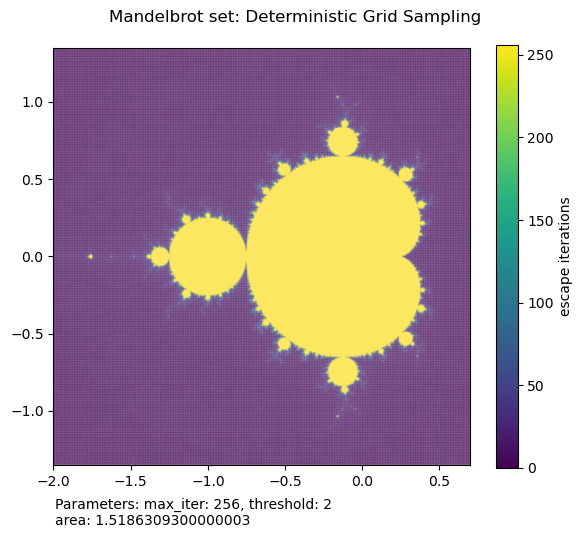

In [56]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 1000000
max_iter = 256

# brute-force deterministic grid sampling
pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Deterministic Grid Sampling', max_iter=max_iter, threshold=2, area=area)

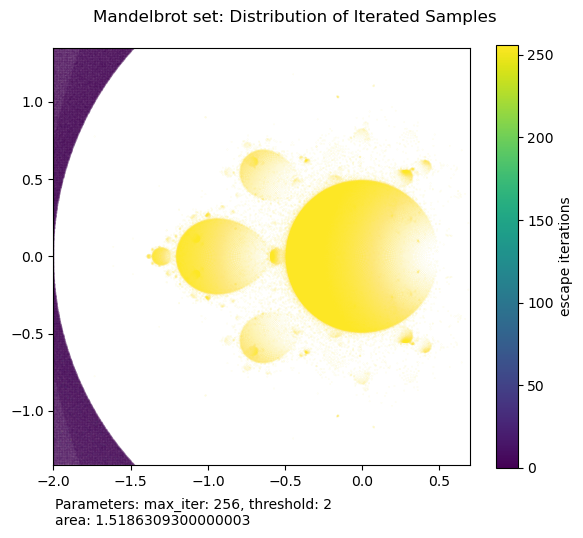

In [111]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 1000000 # run with 100000000 when at home
max_iter = 256

# brute-force deterministic grid sampling
pt_samples = grid_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters, zs = vectorized_mandelbrot_z(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, zs, mandelbrot_iters,
                        sampling_method='Distribution of Iterated Samples', max_iter=max_iter, threshold=2, area=area)

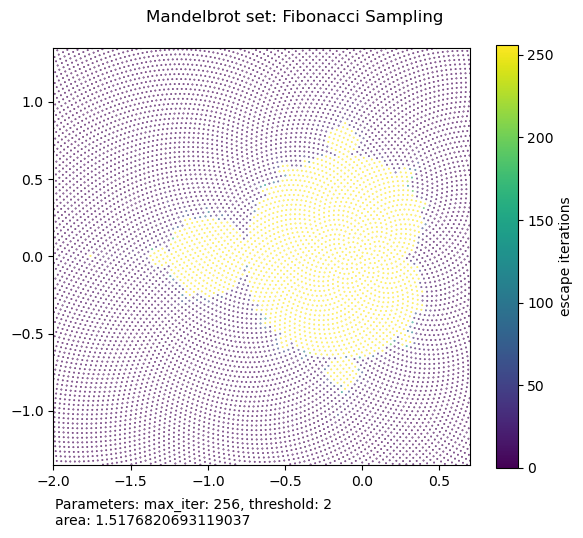

In [83]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 20000
max_iter = 256

# deterministic fibonacci spiral sampling
pt_samples = fibonacci_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters,
                        sampling_method='Fibonacci Sampling', max_iter=max_iter, threshold=2, area=area)

The following procedure tests the three sampling types using a single simulation per type.

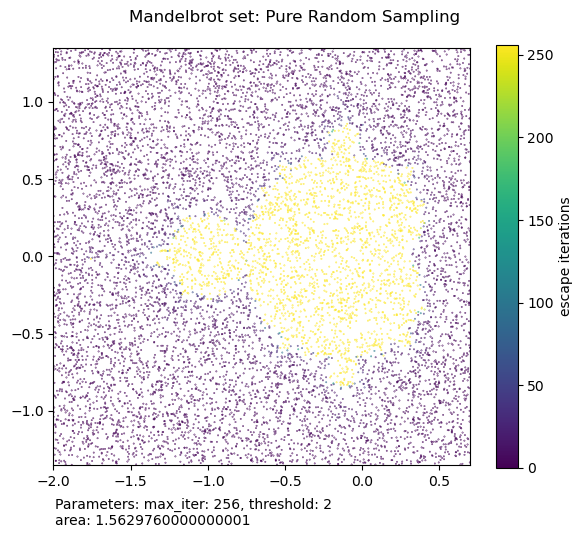

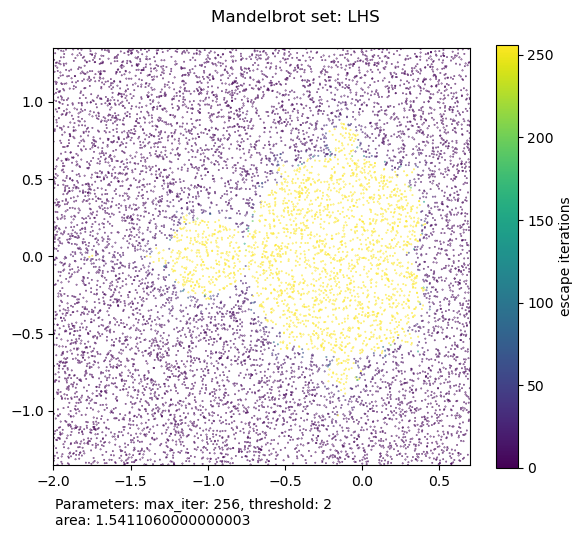

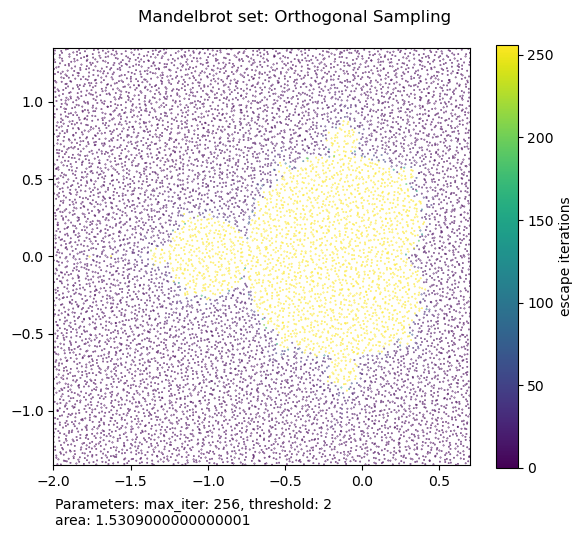

In [57]:
half = False

if half: xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35
else: xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

# test pure random sampling
pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='Pure Random Sampling', max_iter=max_iter, threshold=2, area=area)

# test LHS
pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='LHS', max_iter=max_iter, threshold=2, area=area)

# test orthogonal sampling
pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, 10)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half,
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)

As the Mandelbrot set is symmetrical along the real number axis, it is sufficient to sample only half the complex plane to get an estimate of half of the area.

C:\Users\mihbo\AppData\Local\Temp\ipykernel_11128\2843115543.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


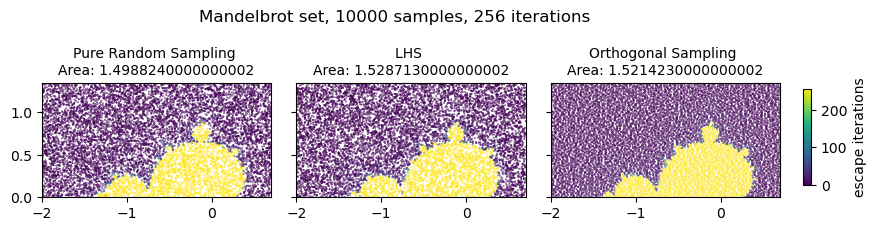

In [130]:
half = True

if half: xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35
else: xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
sample_size = 10000
max_iter = 256

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(8, 2.4)

# test pure random sampling
pt_samples = pure_random_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[0],
                        sampling_method='Pure Random Sampling', max_iter=max_iter, threshold=2, area=area)
axs[0].set_xlim((xmin, xmax))
axs[0].set_ylim((ymin, ymax))
axs[0].set_aspect('equal')
axs[0].set_title(f"Pure Random Sampling \nArea: {area}", fontsize='medium')

# test LHS
pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, sample_size)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[1],
                        sampling_method='LHS', max_iter=max_iter, threshold=2, area=area)
axs[1].set_xlim((xmin, xmax))
axs[1].set_ylim((ymin, ymax))
axs[1].set_aspect('equal')
axs[1].set_title(f"LHS \nArea: {area}", fontsize='medium')

# test orthogonal sampling
pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, sample_size, 10)
complex_samples = coords_to_complex(pt_samples)
mandelbrot_iters = vectorized_mandelbrot(complex_samples, max_iter)
area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters, half=half)
scat = plot_samples_mandelbrot(xmin, xmax, ymin, ymax, complex_samples, mandelbrot_iters, half=half, ax=axs[2],
                        sampling_method='Orthogonal Sampling', max_iter=max_iter, threshold=2, sub_lvl=10, area=area)
axs[2].set_xlim((xmin, xmax))
axs[2].set_ylim((ymin, ymax))
axs[2].set_aspect('equal')
axs[2].set_title(f"Orthogonal Sampling \nArea: {area}", fontsize='medium')

cbar_ax = fig.add_axes([1.01, 0.25, 0.01, 0.4])
fig.suptitle(f"Mandelbrot set, {sample_size} samples, {max_iter} iterations")
fig.colorbar(scat, label='escape iterations', cax=cbar_ax)

plt.tight_layout()
plt.show()

The next procedure runs 1000 simulations per parameter configuration (sample size, iterations) and plots the statistics for all different sampling strategies.

In [34]:
# xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
xmin, xmax, ymin, ymax = -2.0, 0.7, 0, 1.35 # takes only positive Im(c) region
sample_range = np.array([x for x in np.arange(10, 100, 1, dtype=int) if get_median_divisor(x) not in (1, x)])**2 # avoid prime numbers
# iter_range = np.power(2, np.arange(1, 11, 1), dtype=int)
iter_range = np.arange(10, 1000, 30)
num_runs = 1000

sampling_types = ['random', 'LHS', 'ortho']

df_area_strategies = []

for sampling_type in sampling_types:
    df_area_strategies.append(parameter_exploration(xmin, xmax, ymin, ymax, sample_range, iter_range, num_runs, sampling_type=sampling_type, half=True))

df_area = pd.concat(df_area_strategies)

# Save DataFrame to .csv
df_area.to_csv(f"area_data_{num_runs}_runs.csv")
    

KeyboardInterrupt: 

The data from a previous execution can be read through the following procedure.

In [10]:
sample_range = np.array([x for x in np.arange(10, 100, 1, dtype=int) if get_median_divisor(x) not in (1, x)])**2 # avoid prime numbers
# iter_range = np.power(2, np.arange(1, 11, 1), dtype=int)
iter_range = np.arange(2, 1000)

df_area = pd.read_csv("area_data.csv")
print(df_area.head)
print(pd.unique(df_area['Simulation']).shape)

<bound method NDFrame.head of          Unnamed: 0 Strategy  Simulation  Iterations  Samples      Area
0                 0   random         0.0         2.0    100.0  2.988900
1                 1   random         1.0         2.0    100.0  2.733750
2                 2   random         2.0         2.0    100.0  3.316950
3                 3   random         3.0         2.0    100.0  3.025350
4                 4   random         4.0         2.0    100.0  2.952450
...             ...      ...         ...         ...      ...       ...
2069995      689995    ortho       995.0      1024.0   9801.0  0.756446
2069996      689996    ortho       996.0      1024.0   9801.0  0.753099
2069997      689997    ortho       997.0      1024.0   9801.0  0.751240
2069998      689998    ortho       998.0      1024.0   9801.0  0.760165
2069999      689999    ortho       999.0      1024.0   9801.0  0.751240

[2070000 rows x 6 columns]>
(1000,)


The results from the series of simulations are visualised in a multiple plots.

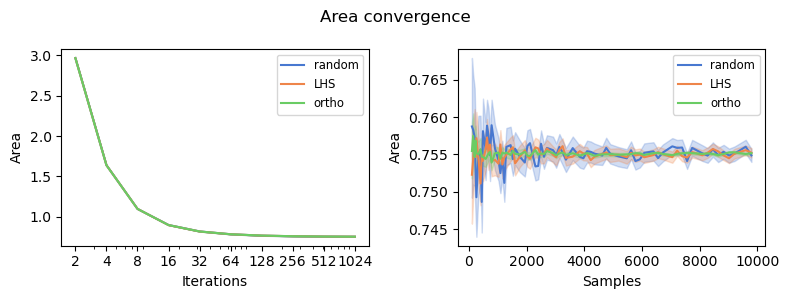

In [13]:
# errorbar = ('sd', 1)
errorbar = ('ci', 95)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
fig.suptitle(f"Area convergence")
# sns.lineplot(df_area, x='Iterations', y='Area', hue='Strategy', palette='muted', errorbar=errorbar, ax=axs[0], err_kws={'alpha':0.25})
sns.lineplot(df_area[df_area['Samples'] == df_area['Samples'].max()], x='Iterations', y='Area', hue='Strategy',
             palette='muted', errorbar=errorbar, ax=axs[0], err_kws={'alpha':0.25})
sns.lineplot(df_area[df_area['Iterations'] == df_area['Iterations'].max()], x='Samples', y='Area', hue='Strategy', 
             palette='muted', errorbar=errorbar, ax=axs[1], err_kws={'alpha':0.25})
axs[0].set_xticks(iter_range, labels=iter_range)
axs[0].legend(fontsize='small')
axs[1].legend(fontsize='small')
plt.tight_layout()
plt.show()

To get an informative picture of the distribution of each sampling methods, the results are plotted in a series of histograms, using the parameters yielding the highest precision in the previous experiment (10000 samples and 1024 iterations).

Area sample mean (random sampling): 0.7550946694214878
Area sample variance (random sampling): 0.00010092614993707745
Area sample standard deviation (random sampling): 0.010046200771290481
Area sample mean (LHS sampling): 0.7550946694214878
Area sample variance (LHS sampling): 0.00010092614993707745
Area sample standard deviation (LHS sampling): 0.010046200771290481
Area sample mean (ortho sampling): 0.7550946694214878
Area sample variance (ortho sampling): 0.00010092614993707745
Area sample standard deviation (ortho sampling): 0.010046200771290481


C:\Users\mihbo\AppData\Local\Temp\ipykernel_16276\202276993.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_area_subset = df_area[df_area['Iterations'] == df_area['Iterations'].max()][df_area['Samples'] == df_area['Samples'].max()]


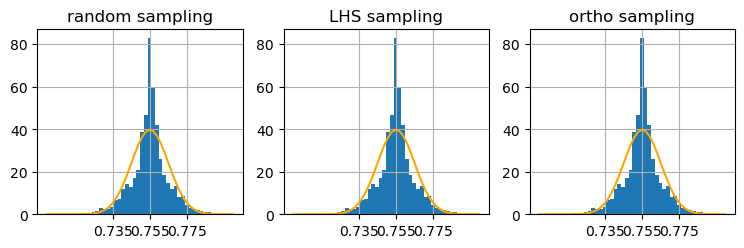

In [30]:
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
num_runs = 1000

sampling_types = ['random', 'LHS', 'ortho']

df_area_subset = df_area[df_area['Iterations'] == df_area['Iterations'].max()][df_area['Samples'] == df_area['Samples'].max()]

# fig, axs = plt.subplots(1, len(sampling_types), sharex=True, sharey=True)
fig, axs = plt.subplots(1, len(sampling_types))
fig.set_size_inches(9, 2.4)
# fig.suptitle(f"Estimated area distribution")

for i, sampling_type in enumerate(sampling_types):
    sample_mean = df_area_subset['Area'].mean()
    sample_var = df_area_subset['Area'].var()
    sample_std = df_area_subset['Area'].std()
    print(f"Area sample mean ({sampling_type} sampling): {sample_mean}")
    print(f"Area sample variance ({sampling_type} sampling): {sample_var}")
    print(f"Area sample standard deviation ({sampling_type} sampling): {sample_std}")
    df_area_subset['Area'].hist(bins=num_runs//20, ax=axs[i], density=True)

    norm_x = np.linspace(df_area_subset['Area'].min(), df_area_subset['Area'].max(), 50)
    axs[i].plot(norm_x, stats.norm.pdf(norm_x, sample_mean, sample_std), c='orange')
    axs[i].set_title(f"{sampling_type} sampling")
    ticks = [sample_mean-2*sample_std, sample_mean, sample_mean+2*sample_std]
    axs[i].set_xticks(ticks, labels=['{:.{}f}'.format(t, 3) for t in ticks])

An enhanced sampling method is tested which narrows down the boundary region of the Mandelbrot sampling using deterministic pre-sampling.

In [142]:
sample_size = 10000
max_iter = 256
num_runs = 100

area_array = []
samples_array = []
for i in range(num_runs):
    area, samples = boundary_sampling_method(-2.0, 0.7, -1.35, 1.35, 1024, 10, 10, 10, 10000, 10000)
    area_array.append(area)
    samples_array.append(samples)
print(np.mean(np.array(area_array)))
print(np.std(np.array(area_array)))

1.5106806373056998
0.0066634073435642965


In [167]:
print(df_area)
print(pd.unique(df_area['Area']))

    Strategy  Simulation  Iterations  Samples      Area
0      ortho         0.0       512.0  10000.0  1.511217
1      ortho         1.0       512.0  10000.0  1.510488
2      ortho         2.0       512.0  10000.0  1.513404
3      ortho         3.0       512.0  10000.0  1.509030
4      ortho         4.0       512.0  10000.0  1.517049
..       ...         ...         ...      ...       ...
995    ortho       995.0       512.0  10000.0  1.503927
996    ortho       996.0       512.0  10000.0  1.510488
997    ortho       997.0       512.0  10000.0  1.516320
998    ortho       998.0       512.0  10000.0  1.508301
999    ortho       999.0       512.0  10000.0  1.514133

[1000 rows x 5 columns]
[1.511217 1.510488 1.513404 1.50903  1.517049 1.509759 1.512675 1.514862
 1.508301 1.514133 1.519236 1.501011 1.511946 1.515591 1.518507 1.522881
 1.517778 1.524339 1.519965 1.507572 1.51632  1.506843 1.522152 1.502469
 1.520694 1.521423 1.525797 1.50174  1.506114 1.498824 1.52361  1.503198
 1.505385 1

## Statistical testing

Statistical testing of the simulation will allow to to quantify out confidence in how much different method differ.

This consists of two phases:

Comparing each method (Classic Monte Carlo, LHS, Orthogonal, Improved stochastic (yet to be devised)) against our estimated ground truth, $A_{m*}$

To do so we perform a one sample T-test between the area of $A_{m*}$, which we call $\mu_{0}$ and the expected value of the area obtained from each of our methods $\hat{X}$.
Our obtained value of the area from $A_{m*}$, $X_{0}$ does not vary accross runs (it only depends on the coarseness of the grid and not on the spread of the samples). 
However, the estimate of the area using one of our sampling methods $\hat{X}$ does vary, meaning we need to take into account our sample standard deviation $S_{\bar{x}}$. This makes a one sample t-test the approriate choice. This results in the following test statistic:

$T=\frac{X-\mu_0}{s_{\bar{x}}}$

We check to see if the T-statistic is outside a critcal region of our choosing (for example, for a two sided test |T. Actual| > 1.96 for $\alpha = 0.05$).
We also need to test if the distribution obtained from our simulations conform to the assumptions of the T-Test (i.i.d. random sample, etc.).


We first perform 4 pairwise tests:

$\hat{X}_{Classic Monte Carlo}$ vs. $\mu_{0}$

$\hat{X}_{LHS}$ vs. $\mu_{0}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\mu_{0}$

$\hat{X}_{Improved Stochastic Method}$ vs. $\mu_{0}$


As soon as we have a statistical estimate of the difference between the area estimated by out methods, we test the difference between methods using a two sample test Welch test (as the sample variances are known but the population variances are not. For this we use the following test statistic:


$T_{Welch} = \frac{\bar{X}-\bar{Y}}{\sqrt{\frac{S_x^2}{n_x}+\frac{S_y^2}{n_y}}}$


$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{LHS}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{Classic Monte Carlo}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Orthogonal Sampling}$

$\hat{X}_{LHS}$ vs. $\hat{X}_{Improved Stochastic Method}$

$\hat{X}_{Orthogonal Sampling}$ vs. $\hat{X}_{Improved Stochastic Method}$







In [1]:


# t-test:https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
# one sample t_test

scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate', alternative='two-sided', *, keepdims=False)


# welch's t-test: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# two sample t_test, put equal variances at False
scipy.stats.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0, *, keepdims=False)

SyntaxError: incomplete input (2506481983.py, line 7)

## New Method for improving convergence

In [38]:
def check_grid_status(xmin, xmax, ymin, ymax, n_p, max_iter, threshold):
    """
    Function to check whether the grid is inside, outside, or on the boundary of the mandelbrot set.
    """
    # n_p is the number of points to sample on the edge
    # create an array of n points on the boundary

    x_1 = np.full((n_p,),xmin)
    y_1 = np.linspace(ymin*1j, ymax*1j, n_p)
    points_1 =  x_1 + y_1
    x_2 = np.linspace(xmin, xmax, n_p)
    y_2 = np.full((n_p,),ymax*1j)
    points_2 =  x_2 + y_2
    x_3 = np.full((n_p,),xmax)
    y_3 = np.linspace(ymin*1j, ymax*1j, n_p)
    points_3 =  x_3 + y_3
    x_4 = np.linspace(xmin, xmax, n_p)
    y_4 = np.full((n_p,),ymin*1j)
    points_4 =  x_1 + y_1

    # points_i contains the points on one side of the grid boundary
    points = np.concatenate((points_1, points_2, points_3, points_4))

    diverged_at = vectorized_mandlebrot(points, max_iter, threshold)

    if (diverged_at == np.full(diverged_at.shape,max_iter)).all():
        return 'in_set'
    elif (diverged_at != np.full(diverged_at.shape,max_iter)).all():
        return 'out_set'
    else:
        return 'boundary'
    
    return None

print(check_grid_status(0., 0.5, 0, 0.5, 10000, 256, 2))
print(check_grid_status(0.1, 0.2, 0.1, 0.2, 10000, 256, 2))

boundary
in_set


In [39]:
def grow_grid(xmin, xmax, ymin, ymax, delta_x, delta_y, north = True, east = True, west = True, south = True):

    """
    function to grow grid in the given specified directiom
    """
    
    xmin_new, xmax_new, ymin_new, ymax_new = xmin, xmax, ymin, ymax
    if north:
        ymax_new = ymax + delta_y
    if south:
        ymin_new = ymin - delta_y
    if east:
        xmax_new = xmax + delta_x
    if west:
        xmin_new = xmin - delta_x

    return xmin_new, xmax_new, ymin_new, ymax_new

-0.6900000000000002 -0.20999999999999985 0 0.29000000000000015


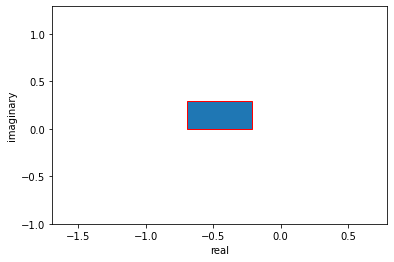

In [40]:
xmin, xmax, ymin, ymax = -0.5,-0.4,0,0.1

while check_grid_status(xmin, xmax, ymin, ymax, 100, 256, 2) == 'in_set':
    xmin, xmax, ymin, ymax = grow_grid(xmin, xmax, ymin, ymax, 0.01, 0.01, south=False)


print(xmin, xmax, ymin, ymax)
fig, ax = plt.subplots()
polygon = mp.Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)], closed=True, edgecolor='r')
ax.add_patch(polygon)
ax.set_xlim(xmin-1, xmax+1)
ax.set_ylim(ymin-1, ymax+1)
plt.xlabel('real')
plt.ylabel('imaginary')
plt.show()


In [41]:
def create_subgrids(xmin, xmax, ymin, ymax, rows, cols):
    subgrids = []

    # Calculate the step size for rows and columns
    row_step = (ymax - ymin) / rows
    col_step = (xmax - xmin) / cols

    # Loop through rows and columns to create subgrids
    for i in range(rows):
        for j in range(cols):
            # Calculate vertices of the current subgrid
            subgrid_xmin = xmin + j * col_step
            subgrid_xmax = subgrid_xmin + col_step
            subgrid_ymin = ymin + i * row_step
            subgrid_ymax = subgrid_ymin + row_step

            # Store vertices in a dictionary
            subgrid = {
                'xmin': subgrid_xmin,
                'xmax': subgrid_xmax,
                'ymin': subgrid_ymin,
                'ymax': subgrid_ymax
            }

            # Add the subgrid to the list
            subgrids.append(subgrid)

    return subgrids

# Example usage
xmin, xmax, ymin, ymax = 1, 5, 2, 6
rows, cols = 2, 2
subgrids = create_subgrids(xmin, xmax, ymin, ymax, rows, cols)

# Print the result
for i, subgrid in enumerate(subgrids, start=1):
    print(f"Subgrid {i}: {subgrid}")

Subgrid 1: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 2: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 2.0, 'ymax': 4.0}
Subgrid 3: {'xmin': 1.0, 'xmax': 3.0, 'ymin': 4.0, 'ymax': 6.0}
Subgrid 4: {'xmin': 3.0, 'xmax': 5.0, 'ymin': 4.0, 'ymax': 6.0}


In [45]:
iterations, threshold = 1024, 2
xmin, xmax, ymin, ymax = -2.0, 0.7, -1.35, 1.35
rows, cols = 10, 10
subgrids = create_subgrids(xmin, xmax, ymin, ymax, rows, cols)
Area = 0
samples = 0
for i, subgrid in enumerate(subgrids):
    xmin, xmax, ymin, ymax = subgrid.values()
    grid_status = check_grid_status(xmin, xmax, ymin, ymax, 100, iterations, threshold)
    samples = samples + 4000
    if grid_status == 'in_set':
        Area = Area + ((xmax - xmin) * (ymax - ymin))
    elif grid_status== 'boundary':

        pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, 10000, 10)
        complex_samples = coords_to_complex(pt_samples)
        mandelbrot_iters = vectorized_mandelbrot(complex_samples, iterations,threshold)
        area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
        Area = Area + area
        samples = samples + 10000
    elif grid_status == 'out_set':
        Area = Area
print(Area)
print(samples)

1.5096860999999995
710000


In [58]:
def new_sampling_method(xmin, xmax, ymin, ymax, iterations, threshold, rows, cols, samples_per_grid_boundary, samples_per_grid, total_samples):    
    subgrids = create_subgrids(xmin, xmax, ymin, ymax, rows, cols)
    Area = 0
    samples = 0
    Subgrids_to_sample = []
    for i, subgrid in enumerate(subgrids):
        xmin, xmax, ymin, ymax = subgrid.values()
        grid_status = check_grid_status(xmin, xmax, ymin, ymax, samples_per_grid_boundary, iterations, threshold)
        samples = samples + (4*samples_per_grid_boundary)
        if grid_status == 'in_set':
            Area = Area + ((xmax - xmin) * (ymax - ymin))
        elif grid_status== 'boundary':
            Subgrids_to_sample.append(subgrid)
        elif grid_status == 'out_set':
            Area = Area
    samples_per_grid = int((total_samples - samples) / len(Subgrids_to_sample))

    for subgrid in Subgrids_to_sample:
        xmin, xmax, ymin, ymax = subgrid.values()
        # pt_samples = orthogonal_sampling(xmin, xmax, ymin, ymax, samples_per_grid, 10)
        pt_samples = latin_hypercube_sampling(xmin, xmax, ymin, ymax, samples_per_grid)
        complex_samples = coords_to_complex(pt_samples)
        mandelbrot_iters = vectorized_mandelbrot(complex_samples, iterations,threshold)
        area = calc_area(xmin, xmax, ymin, ymax, mandelbrot_iters)
        Area = Area + area
        samples = samples + samples_per_grid

    return Area, samples

In [70]:
num_runs = 100
Area = []
Samples = []
for i in range(num_runs):
    area, samples = new_sampling_method(-2.0, 0.7, -1.35, 1.35, 1024, 2, 10, 10, 10, 10000, 10000)
    Area.append(area)
    Samples.append(samples)
print(np.mean(np.array(Area)))
print(np.std(np.array(Area)))

    

1.510752404145078
0.006724739458289314


In [71]:
print(np.mean(np.array(Samples)))


9983.0


In [3]:
array = np.array([[1,2],[1,2]])
df_array = pd.DataFrame(array, columns=['a', 'b'])
df_array.to_csv("test_array")